In [9]:
%autoreload 2
%matplotlib inline 

In [10]:
%run smoothDMparticles.py

In [11]:
import sys
sys.path.append("../")
import matplotlib.pyplot as plt

In [12]:
from sklearn.neighbors.kde import KernelDensity

In [23]:
import matplotlib.pyplot as plt

In [43]:
import extract_catalog as ec
import get_DM_centroids as getDM
import cPickle
from scipy.stats import gaussian_kde as kde 

In [81]:
import scipy.misc 
from scipy import ndimage

In [82]:
face = scipy.misc.face(gray=True)

In [83]:
face.shape

(768, 1024)

In [14]:
data_path = "../../data/"

## 1. extract data 

In [117]:
clstNo = [0]

In [118]:
bandwidth = 30 * 4.45 

In [119]:
coord_dict = ec.get_DM_particles(clstNo, DM_f, dataPath="../../data/")
clst = coord_dict[clstNo[0]]

In [120]:
fhat = \
    getDM.make_histogram_with_some_resolution(coord_dict[clstNo[0]], 
                                              resolution=bandwidth / 2.)

## what the histogram looks like

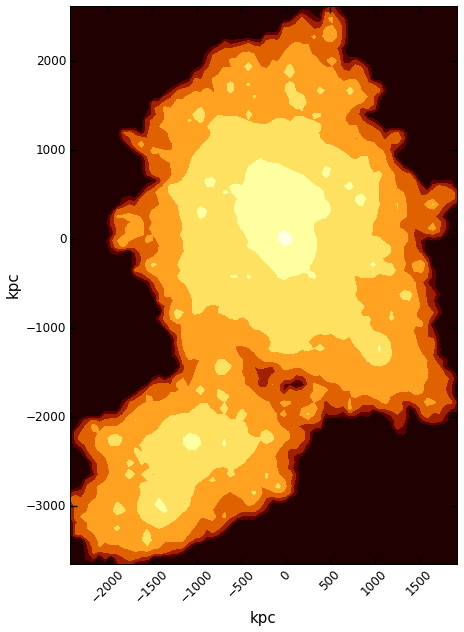

In [121]:
fhat["log_est"] = np.log10(fhat["estimate"] + 1.)
plt.figure(figsize=(15, 10))
plt.subplot('111', axisbg='black', aspect='equal',)

plt.xticks(rotation=45)
plt.contourf(fhat["eval_points"][0], fhat["eval_points"][1],
             fhat["log_est"].transpose(), cmap=plt.cm.afmhot)
plt.xlabel('kpc')
plt.ylabel('kpc')

## what the over smoothed plot looks like

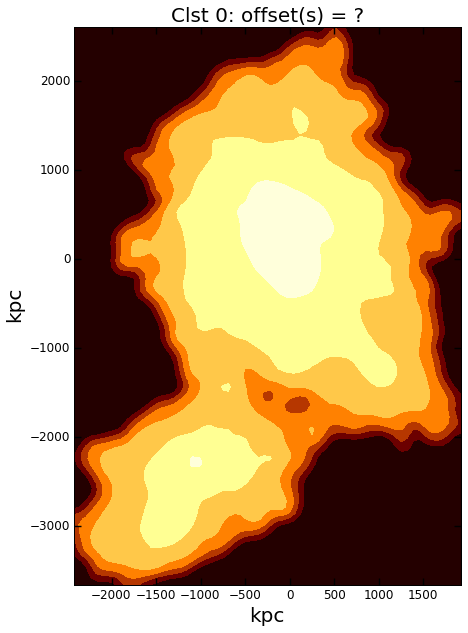

In [123]:
fontsize=20
plt.figure(figsize=(15, 10))
plt.subplot('111', axisbg='black', aspect='equal',)
# I have no freaking clue what sigma refers to.
# It doesn't say in the documentation.
# Perhaps it is how much the signal varies within a region.
smoothed_z = \
    ndimage.gaussian_filter(fhat["log_est"], sigma=1
                           ).transpose()
plt.contourf(fhat["eval_points"][0], fhat["eval_points"][1],
             smoothed_z, cmap=plt.cm.afmhot)
plt.title("Clst {0}: offset(s) = {1}".format(clstNo[0], '?'))
plt.xlabel('kpc', size=fontsize)
plt.ylabel('kpc', size=fontsize)

In [ ]:
bw_method = bandwidth
%time KDE = kde(, bw_method=bw_method)
%time density = KDE(coords[:2, sample_ix])

## 2. downsample to 1% of data points
```Python
size = len(coords)
sample_ix = \
    np.random.choice(range(0, size), 1e-2 * size, 
                     replace=False)
```

## 3. do KDE on downsampled data points 

30 arcsecs * 4.45 kpc / arcsec 

code that Will does not like

```Python
max_coords = np.max(coords, axis=0)
max_coords = np.array([int(c) for c in max_coords])

min_coords = np.min(coords, axis=0)
min_coords = np.array([int(c) for c in min_coords])
slice_dim = [0, 1]
grid_width = 2
x_grid, y_grid = \
    np.meshgrid(np.arange(min_coords[slice_dim[0]], 
                          max_coords[slice_dim[0]], grid_width), 
                np.arange(min_coords[slice_dim[1]], 
                          max_coords[slice_dim[1]], grid_width))
grid_coords = np.array([list(coord) 
                        for coord in 
                        zip(x_grid.ravel(), 
                            y_grid.ravel())])
%time kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(coords[sample_ix, :2])
%time density = kde.score_samples(coords[sample_ix, :2])  
fhat_stars = cPickle.load(open("../../data/fhat_I_lum.pkl", "r"))

densest_ix = np.argsort(density)[::-1][0]
DM_dens_peak = np.array([coords[densest_ix, 0], 
                         coords[densest_ix, 1]])
gal_peak = np.array([fhat_stars[clstNo[0]]["peaks_xcoords"][0], 
                     fhat_stars[clstNo[0]]["peaks_ycoords"][0]])
offsets = DM_dens_peak - gal_peak

offset = np.sqrt(np.sum(np.dot(offsets, offsets)))
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, axisbg='black', aspect='equal')
ax.scatter(coords[sample_ix, 0],
            coords[sample_ix, 1],
            c=density, edgecolor='', 
            cmap=plt.cm.afmhot, s=1)
ax.plot(coords[densest_ix, 0], coords[densest_ix, 1], 'mo', 
        fillstyle='none',
        mew=2, ms=10, label="smoothed KDE densest DM point")
ax.plot(fhat_stars[clstNo[0]]["peaks_xcoords"][0], 
        fhat_stars[clstNo[0]]["peaks_ycoords"][0], 'bo',
        fillstyle='none',
        mew=2, ms=10, label="galaxy KDE peak")

offset_x = -1300
offset_y = -1500
ax.plot([offset_x,  bandwidth + offset_x], 
        [offset_y, offset_y], 
        label='bandwidth', color='yellow')
# _ = ax.set_xlim(-250, 3000)
# _ = ax.set_ylim(-250, 2500)
ax.text(bandwidth + offset_x + 50, 
        offset_y, "kernel bandwidth", color='white', size=30)
ax.set_title("Cluster: {0}, offset = {1:.0f} kpc".format(clstNo[0], offset))
ax.set_xlabel("kpc", size=30)
ax.set_ylabel("kpc", size=30)

```

The following is way too slow
```Python
from scipy.stats import gaussian_kde as kde 
%time KDE = kde(coords[:2, sample_ix], bw_method=bw_method)
%time density = KDE(coords[:2, sample_ix])
```